# CSC 535: Deep Learning Final Project



# 0. Preliminaries
## 0.1 Libraries & Dependencies

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers
from keras.applications import xception
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix as CM
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
import numpy as np
import random
import shutil
import pickle
import math
import time
import cv2
import os

## 0.2 Constants

In [2]:
SEED = 13
X_IMAGE_SIZE = 299
M_IMAGE_SIZE = 224
MAX_SAMPLE_SIZE = 2500

FILEPATH = "/content/Seedlings/"
CLASS_LABELS = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 
                'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 
                'Shepherd’s Purse', 'Small-flowered Cranesbill','Sugar beet' ]

## 0.3 Support Functions

In [3]:
def get_images(directory, size):
    Images = []
    Labels = []
    label = 0
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        for i in range(len(CLASS_LABELS)):
            if labels == CLASS_LABELS[i]:
                label = i

        samples = 0
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            if samples == int(MAX_SAMPLE_SIZE / len(CLASS_LABELS)):
                break
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(size, size)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(label)
            samples += 1

    Images = np.array(Images)
    Labels = np.array(Labels)
    return Images, Labels


def get_classlabel(class_code):
    return CLASS_LABELS[class_code]

def plot_history(model_history):
    fig, (plt1, plt2) = plt.subplots(1, 2)
    fig.suptitle('Training History:')

    plt1.plot(model_history.history['accuracy'])
    plt1.plot(model_history.history['val_accuracy'])
    plt1.set_title('Model accuracy')
    plt1.set(ylabel='Accuracy', xlabel='Epoch')
    plt1.legend(['Train', 'Validation'], loc='upper left')
    #plt1.show()

    plt2.plot(model_history.history['loss'])
    plt2.plot(model_history.history['val_loss'])
    plt2.set_title('Model loss')
    plt2.set(ylabel='Loss', xlabel='Epoch')
    plt2.legend(['Train', 'Validation'], loc='upper left')
    #plt2.show()
    plt.show()

def plot_confusion_matrix(truth, predictions):
    fig, ax = plt.subplots(1)
    ax = sns.heatmap(CM(truth, predictions), ax=ax, cmap=plt.cm.gist_heat, annot=True)
    ax.xaxis.tick_top()
    ax.set_xticklabels(CLASS_LABELS, rotation=45, horizontalalignment="left")
    ax.set_yticklabels(CLASS_LABELS, rotation=45)
    plt.title('Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()

def get_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)

    return total_size/1048576

## 0.3 Importing the Dataset

Here we import the dataset direct from the original [source](https://vision.eng.au.dk/plant-seedlings-dataset/).
This has generally taken about 20 minutes during the course of this project.

In [4]:
!wget -O NonsegmentedV2.zip https://vision.eng.au.dk/?download=/data/WeedData/NonsegmentedV2.zip
!unzip -q NonsegmentedV2.zip -d $FILEPATH

--2020-12-07 20:02:04--  https://vision.eng.au.dk/?download=/data/WeedData/NonsegmentedV2.zip
Resolving vision.eng.au.dk (vision.eng.au.dk)... 130.225.18.133
Connecting to vision.eng.au.dk (vision.eng.au.dk)|130.225.18.133|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /data/WeedData/NonsegmentedV2.zip [following]
--2020-12-07 20:02:04--  https://vision.eng.au.dk/data/WeedData/NonsegmentedV2.zip
Reusing existing connection to vision.eng.au.dk:443.
HTTP request sent, awaiting response... 200 OK
Length: 1711818866 (1.6G) [application/zip]
Saving to: ‘NonsegmentedV2.zip’

NonsegmentedV2.zip    0%[                    ]   1.66M   701KB/s               ^C
[NonsegmentedV2.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile direct

In [5]:
# Skip this block if the above has completed;
# This is just to prevent 'Run All' from calling the files before they are unzipped.
time.sleep(90)

Of 5539 total samples:

In [6]:
images, labels = get_images(FILEPATH, X_IMAGE_SIZE) #Extract the training images from the folders.

print("Shape of Images: ", images.shape)
print("Shape of Labels: ", labels.shape)

Shape of Images:  (2496, 299, 299, 3)
Shape of Labels:  (2496,)


Initial data exploration showed that the sample sizes (for the whole dataset) are imbalanced, this is something that will need to be addressed to prevent bias towards the over-represented classes.

**Revision:** Initially it was attempted to use the entire data set with the intention of using an oversampling method. However, simply using the full dataset caused the Colab environment to repeatedly crash from resource over-utilization. Lowering the set size to something that more manageable for the kernel effectively undersampled and solved the imbalance problem.

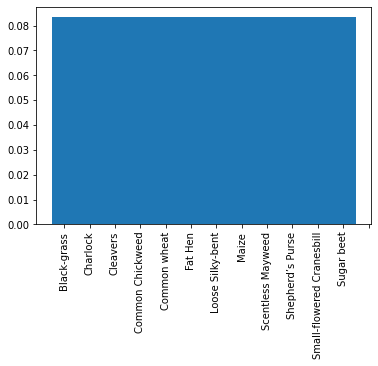

In [7]:
plt.hist(labels, bins = range(len(CLASS_LABELS)+1), align='left', density=True)
plt.xticks(range(len(CLASS_LABELS)+1), CLASS_LABELS, rotation=90)
plt.show()

Below we will take a look at some examples of each class to get a general idea of what each sample in our data looks like.

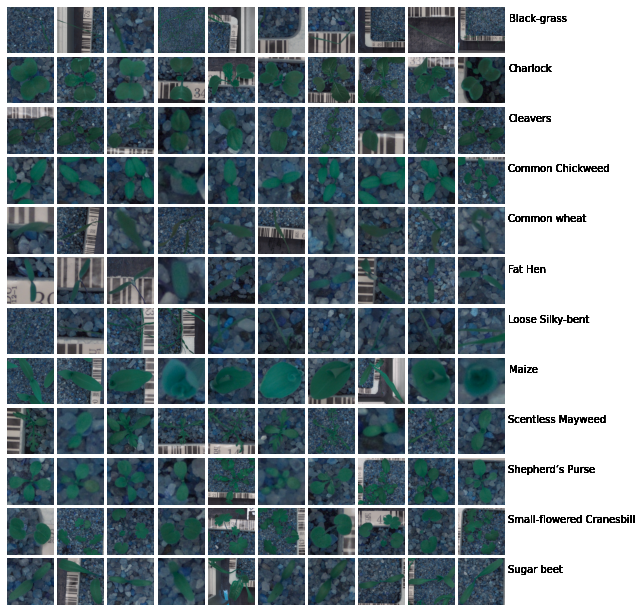

In [8]:
width = 11
fig = plt.figure(1, figsize=(len(CLASS_LABELS), width))
grid = ImageGrid(fig, 111, nrows_ncols=(len(CLASS_LABELS), width), axes_pad=0.05)

for y in range(len(CLASS_LABELS)):
    for x in range(width-1):
        while True:
            impath = FILEPATH + CLASS_LABELS[y] + '/' + str(random.randint(1,500)) + '.png'
            img = cv2.imread(impath)       
            if isinstance(img, np.ndarray):     # This is here because some imreads were returning undefined objects
                img = cv2.resize(img,(X_IMAGE_SIZE, X_IMAGE_SIZE))
                grid[y*width + x].imshow(img)
                grid[y*width + x].axis('off')
                break
        grid[width*y + width-1].text(0, 75, CLASS_LABELS[y], verticalalignment='center')
        grid[width*y + width-1].axis('off')

plt.show()

# 1. Preprocessing

## 1.1 Split Data into Subsets


Here we split the data into training, validation, and testing sets at a ratio of approximately 70:15:15
(Left up to psuedo-randomness)

By storing the images in the array the entire time we will save some memory. Instead of shuffling and duplicating the image data we will shuffle and call the images by indices. This will also ensure that the label and image remain correctly paired without having to pair-wise shuffle.

In [9]:
np.random.seed(seed=SEED)
rnd = np.random.random(size = len(images))
train_idx = rnd < 0.7
valid_idx = (rnd >= 0.7)&(rnd < 0.85 )
test_idx = rnd >= 0.85

print( len(images[train_idx]), len(images[valid_idx]), len(images[test_idx]) )
print( len(images), len(images[train_idx]) + len(images[valid_idx]) + len(images[test_idx]))

1770 367 359
2496 2496


Let us take a look at the new distribution of data to ensure there isn't anything too disproportionate.

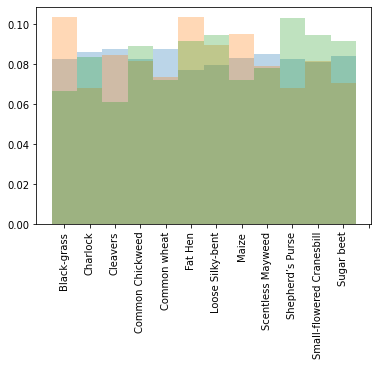

In [10]:
plt.hist(labels[train_idx], bins = range(len(CLASS_LABELS)+1), align='left', density=True, alpha=0.3)
plt.hist(labels[valid_idx], bins = range(len(CLASS_LABELS)+1), align='left', density=True, alpha=0.3)
plt.hist(labels[test_idx], bins = range(len(CLASS_LABELS)+1), align='left', density=True, alpha=0.3)
plt.xticks(range(len(CLASS_LABELS)+1), CLASS_LABELS, rotation=90)
plt.show()

This result is a bit more varied than intended. But this was preferred over uniform data.

**Revision:** During the tuning process I tried a version of the data split uniformly (randomly within the class bucket). Surprisingly, this did not improve the training results.

# 2. Model Generation 

## 2.1 Xception

Xception was designed with a default of images with 299x299x3 dimensions. For that reason the images were resized above to this dimensionality with the intention of improving the performance of this particular transfer model.

Xception requires a specific preprocessing, we accomplish this by calling 'preprocess_input' on all of our images.

In [11]:
x_images = np.zeros((len(images), X_IMAGE_SIZE, X_IMAGE_SIZE, 3), dtype='float32')
for i, img in enumerate(images):
    x_images[i] = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
print('Images shape: {} size: {:,}'.format(x_images.shape, x_images.size))

Images shape: (2496, 299, 299, 3) size: 669,434,688


### 2.1.1 Train and Validation Set

First we will pass the training and validation set through the unmodified Xception model, collecting results based on the original imagenet classifiers.

In [12]:
xception_model = xception.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling='avg',
    classes=1000,
    classifier_activation="softmax",
)
train_x = xception_model.predict(x_images[train_idx], batch_size=32, verbose=1)
valid_x = xception_model.predict(x_images[valid_idx], batch_size=32, verbose=1)

print('Xception train shape: {} size: {:,}'.format(train_x.shape, train_x.size))
print('Xception valid shape: {} size: {:,}'.format(valid_x.shape, valid_x.size))

12/12 [==============================] - 3s 259ms/step
Xception train shape: (1770, 2048) size: 3,624,960
Xception valid shape: (367, 2048) size: 751,616


With the training and validation predictions made on basic imagenet weights, we will next fit a logistic regression predictor in what may be called transductive transfer learning.

Validation Xception Accuracy 0.8555858310626703


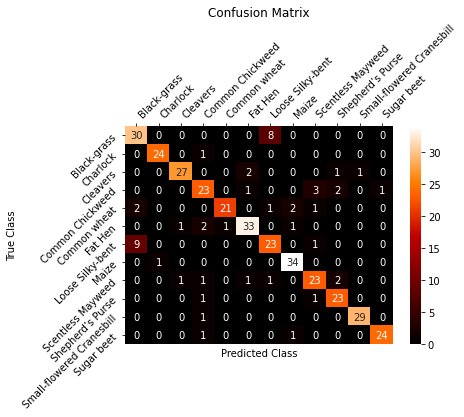

In [13]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=SEED)
logreg.fit(train_x, labels[train_idx])
valid_probs = logreg.predict_proba(valid_x)
valid_preds = logreg.predict(valid_x)

print('Validation Xception Accuracy {}'.format(accuracy_score(labels[valid_idx], valid_preds)))
plot_confusion_matrix(labels[valid_idx], valid_preds)

### 2.1.2 Test Set

Because the logistic regression is fit to the training set results, the validation and test set serve identical purposes. But for sake of consistency we will run a test case anyway.

12/12 [==============================] - 3s 246ms/step
Test Xception Accuracy 0.8802228412256268


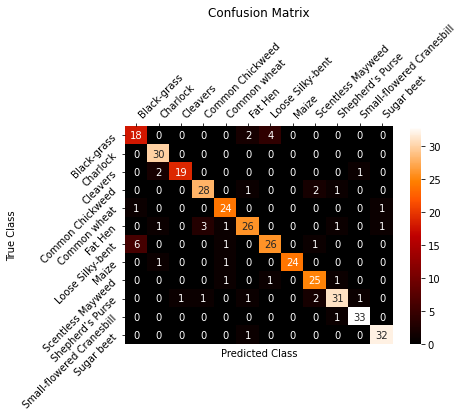

Time to predict:  3.3677287101745605
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./xception_model/assets
Model Size:  2378992
Model Size:  81.94321346282959  MB


In [14]:
# Test Set images have already been preprocessed for xception input
start = time.time()
test_x = xception_model.predict(x_images[test_idx], batch_size=32, verbose=1)
test_probs = logreg.predict_proba(test_x)
test_preds = logreg.predict(test_x)
end = time.time()
print('Test Xception Accuracy {}'.format(accuracy_score(labels[test_idx], test_preds)))
plot_confusion_matrix(labels[test_idx], test_preds)

print("Time to predict: ", end - start)
xception_model.save("./xception_model")
print("Model Size: ", get_size("./xception_model/"), " MB")

Here it is very important that we do a little manual garbage collection to avoid crashing the environment.

**Please Execute Before Proceding.**

In [15]:
del xception_model, logreg, x_images, train_x, valid_x, test_x, valid_probs, valid_preds, test_probs, test_preds


## 2.2 MobileNetV2

### 2.2.1 Pre-processing
We will need to call our images once more, this time in the MobileNet default size (224). In addition, we will need to one-hot encode our labels.

In [16]:
images, labels = get_images(FILEPATH, M_IMAGE_SIZE)
m_images = np.zeros((len(images), M_IMAGE_SIZE, M_IMAGE_SIZE, 3), dtype='float32')
for i, img in enumerate(images):
    m_images[i] = tf.keras.applications.mobilenet.preprocess_input(np.expand_dims(img.copy(), axis=0))
print('Mobile Images shape: {} size: {:,}'.format(m_images.shape, m_images.size))

m_labels = np.eye(len(CLASS_LABELS))[labels]

Mobile Images shape: (2496, 224, 224, 3) size: 375,717,888


### 2.2.2 Default weights with Output Regression

For sake of consistency let us take a look at what kind of results we get with a deployment identical to the one used with Xception above; Default Imagenet weights and a logistic regression classifier fit to the output probabilities.

56/56 [==============================] - 2s 40ms/step
Mobile train shape: (1770, 1000) size: 1,770,000
12/12 [==============================] - 1s 48ms/step
Mobile train shape: (367, 1000) size: 367,000
Validation MobileNetV2 with Regression Accuracy 0.43869209809264303


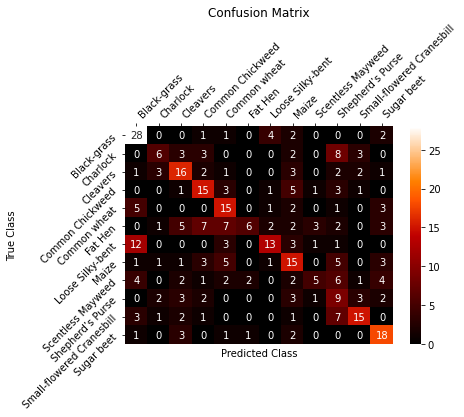

12/12 [==============================] - 1s 45ms/step
Test MobileNetV2 with Regression Accuracy 0.4233983286908078


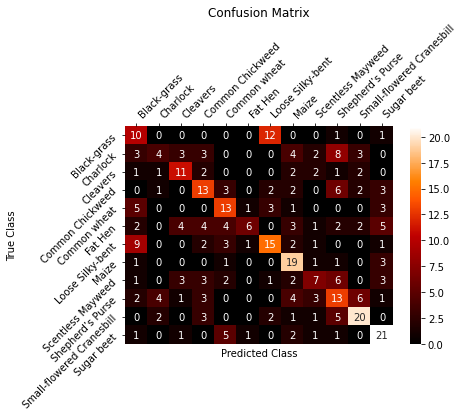

Time to predict:  0.6695873737335205
INFO:tensorflow:Assets written to: ./mobile_model/assets
Model Size:  3237757
Model Size:  16.693934440612793  MB


In [17]:
mobile_model = tf.keras.applications.MobileNetV2(
    input_shape=(M_IMAGE_SIZE,M_IMAGE_SIZE,3),
    alpha=1.0, # Default
    include_top=True, # Default
    weights="imagenet", # Default
    input_tensor=None, # Default
    pooling=None, # Default
    classes=1000, # Default
    classifier_activation="softmax" # Default
)

mobile_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.0002),
    metrics=['accuracy']
)

train_m = mobile_model.predict(m_images[train_idx], batch_size=32, verbose=1)
print('Mobile train shape: {} size: {:,}'.format(train_m.shape, train_m.size))
valid_m = mobile_model.predict(m_images[valid_idx], batch_size=32, verbose=1)
print('Mobile train shape: {} size: {:,}'.format(valid_m.shape, valid_m.size))

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=SEED)
logreg.fit(train_m, labels[train_idx])
valid_probs = logreg.predict_proba(valid_m)
valid_preds = logreg.predict(valid_m)
print('Validation MobileNetV2 with Regression Accuracy {}'.format(accuracy_score(labels[valid_idx], valid_preds)))
plot_confusion_matrix(labels[valid_idx], valid_preds)

start = time.time()
test_m = mobile_model.predict(m_images[test_idx], batch_size=32, verbose=1)
test_preds = logreg.predict(test_m)
test_preds = logreg.predict(test_m)
end = time.time()
print('Test MobileNetV2 with Regression Accuracy {}'.format(accuracy_score(labels[test_idx], test_preds)))
plot_confusion_matrix(labels[test_idx], test_preds)

print("Time to predict: ", end - start)
mobile_model.save("./mobile_model")
print("Model Size: ", get_size("./mobile_model/"), " MB")

### 2.2.3 With Additional Trained Layers

As the above results are not very impressive, let us explore options with additional layers and fitting the whole model.

Epoch 1/30
56/56 - 12s - loss: 2.6112 - accuracy: 0.0927 - val_loss: 2.5010 - val_accuracy: 0.0463
Epoch 2/30
56/56 - 12s - loss: 2.5576 - accuracy: 0.0927 - val_loss: 2.4718 - val_accuracy: 0.1063
Epoch 3/30
56/56 - 12s - loss: 2.5105 - accuracy: 0.1079 - val_loss: 2.4528 - val_accuracy: 0.1390
Epoch 4/30
56/56 - 12s - loss: 2.4751 - accuracy: 0.1209 - val_loss: 2.4319 - val_accuracy: 0.1744
Epoch 5/30
56/56 - 12s - loss: 2.4529 - accuracy: 0.1266 - val_loss: 2.4038 - val_accuracy: 0.2425
Epoch 6/30
56/56 - 12s - loss: 2.4264 - accuracy: 0.1401 - val_loss: 2.3792 - val_accuracy: 0.2398
Epoch 7/30
56/56 - 12s - loss: 2.3885 - accuracy: 0.1554 - val_loss: 2.3371 - val_accuracy: 0.2698
Epoch 8/30
56/56 - 12s - loss: 2.3539 - accuracy: 0.1847 - val_loss: 2.2839 - val_accuracy: 0.3324
Epoch 9/30
56/56 - 12s - loss: 2.2921 - accuracy: 0.2186 - val_loss: 2.2077 - val_accuracy: 0.3324
Epoch 10/30
56/56 - 12s - loss: 2.2450 - accuracy: 0.2192 - val_loss: 2.1116 - val_accuracy: 0.3706
Epoch 11/

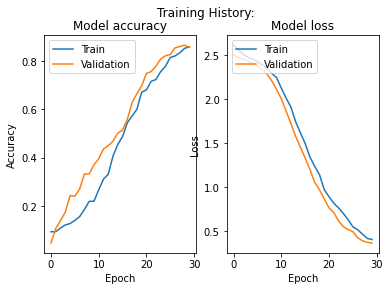

Validation MobileNet Accuracy 0.8802228412256268


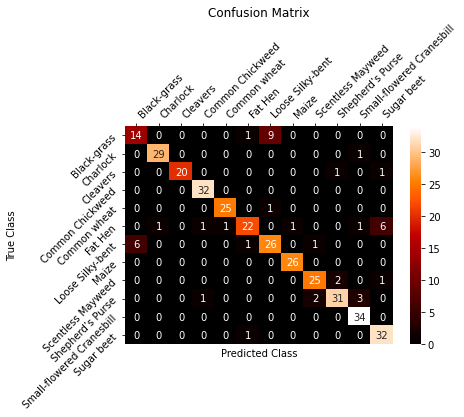

Time to predict:  1.0369081497192383
INFO:tensorflow:Assets written to: ./mobile_model/assets
Model Size:  4524651
Model Size:  46.66439247131348  MB


In [18]:
mobile_net = tf.keras.applications.MobileNetV2(
    input_shape=(M_IMAGE_SIZE,M_IMAGE_SIZE,3),
    alpha=1.0, # Default
    include_top=False,
    weights="imagenet", # Default
    input_tensor=None, # Default
    pooling='avg',
    classes=len(CLASS_LABELS),
    classifier_activation="softmax" # Default
)

mobile_model = models.Sequential()
mobile_model.add(mobile_net)
mobile_model.add(layers.Dense(512, activation='relu'))
mobile_model.add(layers.Dense(512, activation='relu'))
mobile_model.add(layers.Dropout(0.5))
mobile_model.add(layers.Dense(512, activation='relu'))
mobile_model.add(layers.Dropout(0.5))
mobile_model.add(layers.Dense(512, activation='relu'))
mobile_model.add(layers.Dropout(0.5))
mobile_model.add(layers.Dense(len(CLASS_LABELS), activation='softmax'))

mobile_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.00002),
    metrics=['accuracy']
)

history = mobile_model.fit(
    m_images[train_idx], 
    m_labels[train_idx],
    epochs=30,
    batch_size=32,
    verbose=2,
    validation_data=(m_images[valid_idx], m_labels[valid_idx] )
)
plot_history(history)

start = time.time()
test_probs = mobile_model.predict(m_images[test_idx])
test_preds = np.argmax(test_probs, axis=1)
end = time.time()
print('Validation MobileNet Accuracy {}'.format(accuracy_score(labels[test_idx], test_preds)))
plot_confusion_matrix(labels[test_idx], test_preds)

print("Time to predict: ", end - start)
mobile_model.save("./mobile_model")
print("Model Size: ", get_size("./mobile_model/"), " MB")

Numerous hyper-parameters and network shapes were tried without much luck. The change that seemed to help the most was reducing the learning rate a few fold.

**Please Clean the Trash Before Proceding.**

In [19]:
del mobile_model, logreg, m_images, m_labels, test_probs, test_preds, train_m, valid_m, test_m

## 2.3 NASNetMobile
Next we will test NASNetMobile, the next smallest network found in the keras applications library.

The NAS series of networks appear to be intended for transfer learning, so this should be a more promising result.

### 2.3.1 Pre-Processing 

Once again we will need to preprocess the images for this model.
However, as long as the base images and labels are still loaded from MobileNet we shouldn't have to reload those.

As with MobileNet we will need the labels to be one-hot again.

In [20]:
# images, labels = get_images(FILEPATH, M_IMAGE_SIZE)
### This Should have occured above, if not run sequentially, the above will get the images at the proper scale.

n_images = np.zeros((len(images), M_IMAGE_SIZE, M_IMAGE_SIZE, 3), dtype='float32')
for i, img in enumerate(images):
    n_images[i] = tf.keras.applications.nasnet.preprocess_input(np.expand_dims(img.copy(), axis=0))
print('Mobile Images shape: {} size: {:,}'.format(n_images.shape, n_images.size))

n_labels = np.eye(len(CLASS_LABELS))[labels]

Mobile Images shape: (2496, 224, 224, 3) size: 375,717,888


### 2.3.2 Building the Model

Initially I used the same additional layers as MobileNet but found that this model over-fit way faster than MobileNet did. So we train this one with two fewer dense layers and for 10 epochs instead of 30.

Epoch 1/20
56/56 - 12s - loss: 2.8245 - accuracy: 0.1638 - val_loss: 1.5461 - val_accuracy: 0.7057
Epoch 2/20
56/56 - 12s - loss: 2.1385 - accuracy: 0.2921 - val_loss: 1.0446 - val_accuracy: 0.8174
Epoch 3/20
56/56 - 12s - loss: 1.6498 - accuracy: 0.4463 - val_loss: 0.7970 - val_accuracy: 0.8365
Epoch 4/20
56/56 - 12s - loss: 1.3344 - accuracy: 0.5554 - val_loss: 0.6477 - val_accuracy: 0.8583
Epoch 5/20
56/56 - 12s - loss: 1.1072 - accuracy: 0.6379 - val_loss: 0.5296 - val_accuracy: 0.8665
Epoch 6/20
56/56 - 12s - loss: 0.9306 - accuracy: 0.6887 - val_loss: 0.4473 - val_accuracy: 0.8910
Epoch 7/20
56/56 - 12s - loss: 0.7896 - accuracy: 0.7593 - val_loss: 0.3875 - val_accuracy: 0.8883
Epoch 8/20
56/56 - 12s - loss: 0.6561 - accuracy: 0.7966 - val_loss: 0.3516 - val_accuracy: 0.8883
Epoch 9/20
56/56 - 12s - loss: 0.6005 - accuracy: 0.8085 - val_loss: 0.3140 - val_accuracy: 0.8883
Epoch 10/20
56/56 - 12s - loss: 0.5202 - accuracy: 0.8367 - val_loss: 0.2896 - val_accuracy: 0.8937
Epoch 11/

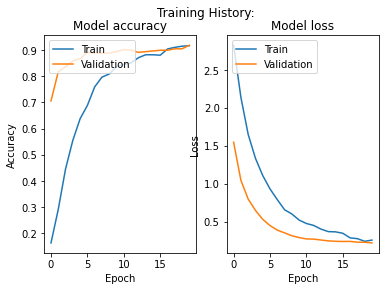

Validation MobileNet Accuracy 0.9025069637883009


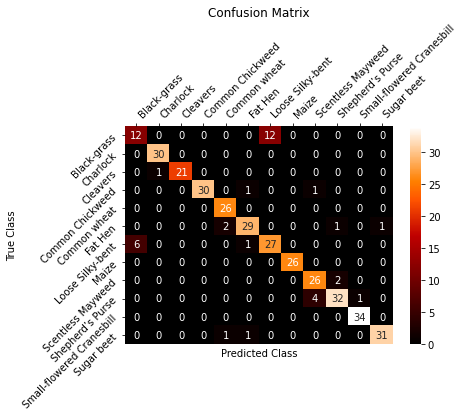

Time to predict:  1.025968074798584
INFO:tensorflow:Assets written to: ./NasNetMobile_model/assets
Model Size:  4495030
Model Size:  40.621413230895996  MB


In [25]:
NasNetMobile_net = tf.keras.applications.NASNetMobile(
    input_shape=(M_IMAGE_SIZE,M_IMAGE_SIZE,3),
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling='avg',
    classes=1000,
)

NasNetMobile_model = models.Sequential()
NasNetMobile_model.add(mobile_net)
NasNetMobile_model.add(layers.Dropout(0.5))
NasNetMobile_model.add(layers.Dense(512, activation='relu'))
NasNetMobile_model.add(layers.Dropout(0.5))
NasNetMobile_model.add(layers.Dense(512, activation='relu'))
NasNetMobile_model.add(layers.Dropout(0.5))
NasNetMobile_model.add(layers.Dense(len(CLASS_LABELS), activation='softmax'))

NasNetMobile_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.00002),
    metrics=['accuracy']
)

history = NasNetMobile_model.fit(
    n_images[train_idx], 
    n_labels[train_idx],
    epochs=20,
    batch_size=32,
    verbose=2,
    validation_data=(n_images[valid_idx], n_labels[valid_idx] )
)
plot_history(history)

start = time.time()
test_probs = NasNetMobile_model.predict(n_images[test_idx])
test_preds = np.argmax(test_probs, axis=1)
end = time.time()
print('Validation MobileNet Accuracy {}'.format(accuracy_score(labels[test_idx], test_preds)))
plot_confusion_matrix(labels[test_idx], test_preds)

print("Time to predict: ", end - start)
NasNetMobile_model.save("./NasNetMobile_model")
print("Model Size: ", get_size("./NasNetMobile_model/"), " MB")

The first results of this model are pretty impressive after the difficulty in tuning MobileNet.